In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
from sklearn.preprocessing import normalize

Using TensorFlow backend.


In [2]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = data_per_word * len(words)
timesteps = 50
dimensions = 3 * 44

In [3]:
def get_bone_pos(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    bone_pos = np.zeros([44, 3]) # [cooridinates x fingers]
#     finger_tip = {}
    if 'right' in frame['hands']:
        bone_pos[0, :] = np.array([frame['hands']['right']['yaw'], frame['hands']['right']['roll'], frame['hands']['right']['pitch']])
        bone_pos[1, :] = np.array(frame['hands']['right']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
            bone_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            bone_pos[2 + 5 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['intermediate']['next_joint'])
            bone_pos[2 + 10 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['proximal']['next_joint'])
            bone_pos[2 + 15 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['metacarpal']['next_joint'])
    if 'left' in frame['hands']:
        bone_pos[22, :] = np.array([frame['hands']['left']['yaw'], frame['hands']['left']['roll'], frame['hands']['left']['pitch']])
        bone_pos[23, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
            bone_pos[4 + 20 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            bone_pos[4 + 25 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['intermediate']['next_joint'])
            bone_pos[4 + 30 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['proximal']['next_joint'])
            bone_pos[4 + 35 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['metacarpal']['next_joint'])

    return bone_pos

In [4]:
import json
import pandas as pd
import numpy as np

In [5]:
x = np.zeros([data_length, timesteps, dimensions])
y = np.array([])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        curr_idx = 0
        pick_frame_every_no = len(json_data) / 50 + 1
        for frame_no, frame in enumerate(json_data):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            bones_pos = get_bone_pos(frame)
            for idx, bone_pos in enumerate(bones_pos):
                x[word_no * data_per_word + data_no, curr_idx, idx * 3: idx * 3 + 3] = bone_pos
            curr_idx += 1

        y = np.append(y, word_no)

In [6]:
x_min = x.min(axis=(0,1), keepdims=True)
x_max = x.max(axis=(0,1), keepdims=True)
x_norm = (x-x_min)/(x_max-x_min)

In [7]:
x_train = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 / 3])
x_test = np.zeros([data_length / 3, timesteps, dimensions])
y_test = np.zeros([data_length / 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx / 3] = x_norm[idx]
        y_test[idx / 3] = y[idx]
    else:
        x_train[idx - idx / 3] = x_norm[idx]
        y_train[idx - idx / 3] = y[idx]

In [8]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 / 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [9]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [10]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=500, batch_size=8, shuffle=True)

Train on 342 samples, validate on 171 samples
Epoch 1/500
342/342 [==============================] - 4s 12ms/step - loss: 3.0046 - acc: 0.0351 - val_loss: 2.9479 - val_acc: 0.0526
Epoch 2/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9548 - acc: 0.0234 - val_loss: 2.9447 - val_acc: 0.0526
Epoch 3/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9502 - acc: 0.0322 - val_loss: 2.9445 - val_acc: 0.0468
Epoch 4/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9550 - acc: 0.0351 - val_loss: 2.9456 - val_acc: 0.0526
Epoch 5/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9406 - acc: 0.0526 - val_loss: 2.9450 - val_acc: 0.0526
Epoch 6/500
342/342 [==============================] - 3s 9ms/step - loss: 2.9413 - acc: 0.0292 - val_loss: 2.9505 - val_acc: 0.0526
Epoch 7/500
342/342 [==============================] - 3s 7ms/step - loss: 2.9319 - acc: 0.0468 - val_loss: 2.9469 - val_acc: 0.0526
Epoch 8/500
342/342 [=

Epoch 62/500
342/342 [==============================] - 2s 7ms/step - loss: 2.9287 - acc: 0.0439 - val_loss: 3.0494 - val_acc: 0.0526
Epoch 63/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9289 - acc: 0.0351 - val_loss: 3.0494 - val_acc: 0.0526
Epoch 64/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9292 - acc: 0.0409 - val_loss: 3.0495 - val_acc: 0.0526
Epoch 65/500
342/342 [==============================] - 3s 8ms/step - loss: 2.9285 - acc: 0.0409 - val_loss: 3.0494 - val_acc: 0.0526
Epoch 66/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9289 - acc: 0.0351 - val_loss: 3.0494 - val_acc: 0.0526
Epoch 67/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9290 - acc: 0.0409 - val_loss: 3.0494 - val_acc: 0.0468
Epoch 68/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9287 - acc: 0.0409 - val_loss: 3.0494 - val_acc: 0.0526
Epoch 69/500
342/342 [==============================] - 2s 6ms

Epoch 123/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9281 - acc: 0.0351 - val_loss: 3.0494 - val_acc: 0.0526
Epoch 124/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9283 - acc: 0.0409 - val_loss: 3.0494 - val_acc: 0.0526
Epoch 125/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9283 - acc: 0.0497 - val_loss: 3.0494 - val_acc: 0.0526
Epoch 126/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9280 - acc: 0.0263 - val_loss: 3.0495 - val_acc: 0.0526
Epoch 127/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9284 - acc: 0.0234 - val_loss: 3.0494 - val_acc: 0.0526
Epoch 128/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9280 - acc: 0.0409 - val_loss: 3.0494 - val_acc: 0.0526
Epoch 129/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9282 - acc: 0.0380 - val_loss: 3.0495 - val_acc: 0.0526
Epoch 130/500
342/342 [==============================] 

342/342 [==============================] - 2s 6ms/step - loss: 2.9278 - acc: 0.0468 - val_loss: 3.0497 - val_acc: 0.0526
Epoch 184/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9280 - acc: 0.0380 - val_loss: 3.0497 - val_acc: 0.0526
Epoch 185/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9281 - acc: 0.0409 - val_loss: 3.0497 - val_acc: 0.0526
Epoch 186/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9278 - acc: 0.0497 - val_loss: 3.0497 - val_acc: 0.0526
Epoch 187/500
342/342 [==============================] - 2s 7ms/step - loss: 2.9316 - acc: 0.0380 - val_loss: 3.0989 - val_acc: 0.0526
Epoch 188/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8899 - acc: 0.0789 - val_loss: 2.9854 - val_acc: 0.0526
Epoch 189/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8225 - acc: 0.0643 - val_loss: 2.8207 - val_acc: 0.0936
Epoch 190/500
342/342 [==============================] - 2s 6ms/step 

Epoch 244/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6767 - acc: 0.1053 - val_loss: 2.8673 - val_acc: 0.0877
Epoch 245/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6805 - acc: 0.0848 - val_loss: 2.8685 - val_acc: 0.1053
Epoch 246/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6671 - acc: 0.0877 - val_loss: 2.8674 - val_acc: 0.0877
Epoch 247/500
342/342 [==============================] - 3s 8ms/step - loss: 2.6650 - acc: 0.1082 - val_loss: 2.8613 - val_acc: 0.0994
Epoch 248/500
342/342 [==============================] - 2s 7ms/step - loss: 2.6758 - acc: 0.0994 - val_loss: 2.8694 - val_acc: 0.0877
Epoch 249/500
342/342 [==============================] - 2s 7ms/step - loss: 2.6940 - acc: 0.1287 - val_loss: 2.8655 - val_acc: 0.0936
Epoch 250/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6770 - acc: 0.1170 - val_loss: 2.8665 - val_acc: 0.0936
Epoch 251/500
342/342 [==============================] 

342/342 [==============================] - 2s 6ms/step - loss: 2.6741 - acc: 0.0965 - val_loss: 2.8644 - val_acc: 0.1111
Epoch 305/500
342/342 [==============================] - 2s 7ms/step - loss: 2.6378 - acc: 0.1140 - val_loss: 2.8533 - val_acc: 0.1111
Epoch 306/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6540 - acc: 0.1023 - val_loss: 2.8517 - val_acc: 0.1053
Epoch 307/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6595 - acc: 0.1053 - val_loss: 2.8521 - val_acc: 0.1170
Epoch 308/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6488 - acc: 0.1257 - val_loss: 2.8505 - val_acc: 0.1053
Epoch 309/500
342/342 [==============================] - 2s 7ms/step - loss: 2.6580 - acc: 0.1053 - val_loss: 2.8681 - val_acc: 0.0994
Epoch 310/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6415 - acc: 0.0906 - val_loss: 2.8507 - val_acc: 0.1111
Epoch 311/500
342/342 [==============================] - 2s 6ms/step 

Epoch 365/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6671 - acc: 0.0906 - val_loss: 2.8418 - val_acc: 0.0994
Epoch 366/500
342/342 [==============================] - 3s 7ms/step - loss: 2.6448 - acc: 0.0994 - val_loss: 2.8420 - val_acc: 0.1053
Epoch 367/500
342/342 [==============================] - 3s 9ms/step - loss: 2.6499 - acc: 0.1082 - val_loss: 2.8522 - val_acc: 0.1228
Epoch 368/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6275 - acc: 0.1170 - val_loss: 2.8426 - val_acc: 0.1053
Epoch 369/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6211 - acc: 0.1140 - val_loss: 2.8389 - val_acc: 0.1111
Epoch 370/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6392 - acc: 0.1257 - val_loss: 2.8466 - val_acc: 0.1053
Epoch 371/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6485 - acc: 0.1170 - val_loss: 2.8405 - val_acc: 0.1053
Epoch 372/500
342/342 [==============================] 

342/342 [==============================] - 2s 6ms/step - loss: 2.5837 - acc: 0.1345 - val_loss: 2.8657 - val_acc: 0.1111
Epoch 426/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6161 - acc: 0.1433 - val_loss: 2.8829 - val_acc: 0.1111
Epoch 427/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6332 - acc: 0.1257 - val_loss: 2.8548 - val_acc: 0.1053
Epoch 428/500
342/342 [==============================] - 2s 6ms/step - loss: 2.5806 - acc: 0.1374 - val_loss: 2.9276 - val_acc: 0.1287
Epoch 429/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6182 - acc: 0.1287 - val_loss: 2.8517 - val_acc: 0.1170
Epoch 430/500
342/342 [==============================] - 2s 6ms/step - loss: 2.5974 - acc: 0.1316 - val_loss: 2.8469 - val_acc: 0.1228
Epoch 431/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6208 - acc: 0.1404 - val_loss: 2.8641 - val_acc: 0.1053
Epoch 432/500
342/342 [==============================] - 2s 6ms/step 

Epoch 486/500
342/342 [==============================] - 2s 6ms/step - loss: 2.5521 - acc: 0.1725 - val_loss: 2.8889 - val_acc: 0.1287
Epoch 487/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6071 - acc: 0.1345 - val_loss: 2.9198 - val_acc: 0.1170
Epoch 488/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6067 - acc: 0.1404 - val_loss: 2.9230 - val_acc: 0.1228
Epoch 489/500
342/342 [==============================] - 2s 6ms/step - loss: 2.5729 - acc: 0.1374 - val_loss: 2.8815 - val_acc: 0.1345
Epoch 490/500
342/342 [==============================] - 2s 6ms/step - loss: 2.6071 - acc: 0.1228 - val_loss: 2.8689 - val_acc: 0.1287
Epoch 491/500
342/342 [==============================] - 2s 6ms/step - loss: 2.5799 - acc: 0.1404 - val_loss: 2.8973 - val_acc: 0.1170
Epoch 492/500
342/342 [==============================] - 2s 6ms/step - loss: 2.5882 - acc: 0.1257 - val_loss: 2.9036 - val_acc: 0.1170
Epoch 493/500
342/342 [==============================] 

In [12]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

171/171 [==============================] - 0s 691us/step
('Test score:', 2.9316717337446603)
('Test accuracy:', 0.10526315789473684)


In [13]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


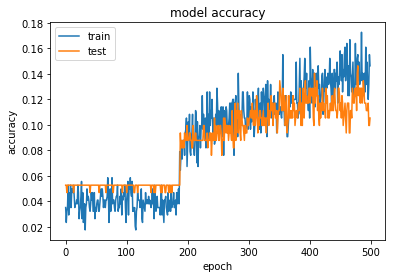

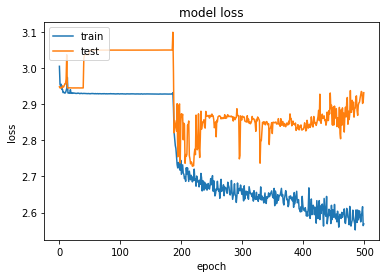

In [14]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()